In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm


### Create dictionary with QC measures for each dataset, analysis and CR strategy

In [2]:
FC_list=['DR0','seed_FC1','DR1','seed_FC0']
Avg_thresh={'DR0':0.75,'seed_FC1':0.65,'DR1':0.60,'seed_FC0':0.55}

CR_list=['raw', 'FD', 'mot6_FD', 'mot6_FD_no_QC', 'mot6_FD_standard', 'mot6_FD_DVARS', 'mot24_FD', 
         'mot6_FD_WM_CSF', 'mot6_FD_aCompCor5', 'mot6_FD_global', 'mot6_FD_highpass', 'mot6_FD_bandpass0.2', 'mot6_FD_bandpass0.1', 'mot6_FD_AROMA', 'optimized']

#CR_list=['raw', 'FD', 'mot6_FD', 'mot6_FD_standard', 'mot6_FD_DVARS']

datasets = ['7_Cryo_aw_f','7_Cryo_med_f1', '7_Cryo_med_f2','7_Cryo_med_f3',
'7_Cryo_mediso_v','7_RT_halo_v', '7_RT_iso_f','7_RT_med_f','47_RT_iso_f','94_Cryo_iso_f','94_Cryo_med_f','94_Cryo_mediso_v',
'94_RT_iso_v','94_RT_mediso_f1','94_RT_mediso_f2','117_Cryo_iso_f','117_Cryo_mediso_v',
'grandjean_aw','grandjean_mediso']

# predominant scan category
dataset_categories={}
dataset_categories['7_Cryo_aw_f']='Unclear'
dataset_categories['7_Cryo_med_f1']='No network signal'
dataset_categories['7_Cryo_med_f2']='No network signal'
dataset_categories['7_Cryo_med_f3']='Unclear'
dataset_categories['7_Cryo_mediso_v']='Good quality'
dataset_categories['7_RT_halo_v']='Unclear'
dataset_categories['7_RT_iso_f']='No network signal'
dataset_categories['7_RT_med_f']='No network signal'
dataset_categories['47_RT_iso_f']='Unclear'
dataset_categories['94_Cryo_iso_f']='Corrupted'
dataset_categories['94_Cryo_med_f']='Unclear'
dataset_categories['94_Cryo_mediso_v']='Unclear'
dataset_categories['94_RT_iso_v']='Unclear'
dataset_categories['94_RT_mediso_f1']='No network signal'
dataset_categories['94_RT_mediso_f2']='Unclear'
dataset_categories['117_Cryo_iso_f']='Corrupted'
dataset_categories['117_Cryo_mediso_v']='Good quality'
dataset_categories['grandjean_aw']='Unclear'
dataset_categories['grandjean_mediso']='Good quality'

optimized_CR={}
optimized_CR['7_Cryo_aw_f']='optimized_CR4'
optimized_CR['7_Cryo_med_f1']='optimized_CR2'
optimized_CR['7_Cryo_med_f2']='optimized_CR3'
optimized_CR['7_Cryo_med_f3']='optimized_CR3'
optimized_CR['7_Cryo_mediso_v']='mot6_FD_highpass'
optimized_CR['7_RT_halo_v']='optimized_CR3'
optimized_CR['7_RT_iso_f']='mot6_FD'
optimized_CR['7_RT_med_f']='optimized_CR2'
optimized_CR['47_RT_iso_f']='mot6_FD_standard'
optimized_CR['94_Cryo_iso_f']='optimized_CR7'
optimized_CR['94_Cryo_med_f']='optimized_CR3'
optimized_CR['94_Cryo_mediso_v']='optimized_CR4'
optimized_CR['94_RT_iso_v']='optimized_CR4'
optimized_CR['94_RT_mediso_f1']='mot6_FD'
optimized_CR['94_RT_mediso_f2']='optimized_CR7'
optimized_CR['117_Cryo_iso_f']='optimized_CR6'
optimized_CR['117_Cryo_mediso_v']='mot6_FD'
optimized_CR['grandjean_aw']='optimized_CR3'
optimized_CR['grandjean_mediso']='mot6_FD_AROMA'


# load all data into a dictionary
FC_stats={}
for CR in CR_list:
    print(CR)
    FC_stats[CR]={}
    for FC in FC_list:
        FC_stats[CR][FC]={}
        for dataset in datasets:
            if CR=='optimized':
                CR_read=optimized_CR[dataset]
            else:
                CR_read=CR
            FC_stats[CR][FC][dataset]={}
            FC_stats[CR][FC][dataset]['CR_read'] = CR_read
            try:
                if dataset=='grandjean_aw':
                    df_dist = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_awake/analysis_QC/analysis_QC/sample_distributions/{FC}_outlier_detection.csv')
                elif dataset=='grandjean_mediso':
                    df_dist = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_mediso/analysis_QC/analysis_QC/sample_distributions/{FC}_outlier_detection.csv')
                else:
                    df_dist = pd.read_csv(f'diagnosis_outputs/{CR_read}/{dataset}/analysis_QC/analysis_QC/sample_distributions/{FC}_outlier_detection.csv')
            except:
                print(f"{CR} is missing in {dataset}")
                FC_stats[CR][FC][dataset]['criterion']=0
                continue
                
            num_scans = df_dist['QC inclusion?'].sum()
            FC_stats[CR][FC][dataset]['num_scans'] = num_scans
            FC_stats[CR][FC][dataset]['Dice'] = df_dist['Dice overlap']
            FC_stats[CR][FC][dataset]['Conf'] = df_dist['DR confound corr.']
            if num_scans<8: # group stats are only considered with at least 8 scans
                continue
                
            if dataset=='grandjean_aw':
                df = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_awake/analysis_QC/analysis_QC/parametric_stats/{FC}_QC_stats.csv')
            elif dataset=='grandjean_mediso':
                df = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_mediso/analysis_QC/analysis_QC/parametric_stats/{FC}_QC_stats.csv')
            else:
                df = pd.read_csv(f'diagnosis_outputs/{CR_read}/{dataset}/analysis_QC/analysis_QC/parametric_stats/{FC}_QC_stats.csv')
            for column in ['Overlap: Prior - Group average', 'Overlap: Prior - Cross-scan variability', 'Avg.: CRsd', 'Avg.: Mean FD']:
                FC_stats[CR][FC][dataset][column] = df[column].values[0]
            try:
                for column in ['Avg.: tDOF']:
                    FC_stats[CR][FC][dataset][column] = df[column].values[0]
            except: # some may have no tDOF difference between scans
                for column in ['Avg.: tDOF']:
                    FC_stats[CR][FC][dataset][column] = 0


raw
FD
mot6_FD
mot6_FD_no_QC
mot6_FD_standard
mot6_FD_DVARS
mot24_FD
mot6_FD_WM_CSF
mot6_FD_aCompCor5
mot6_FD_global
mot6_FD_highpass
mot6_FD_bandpass0.2
mot6_FD_bandpass0.1
mot6_FD_AROMA
optimized


## Inspect scan-level indices across CR

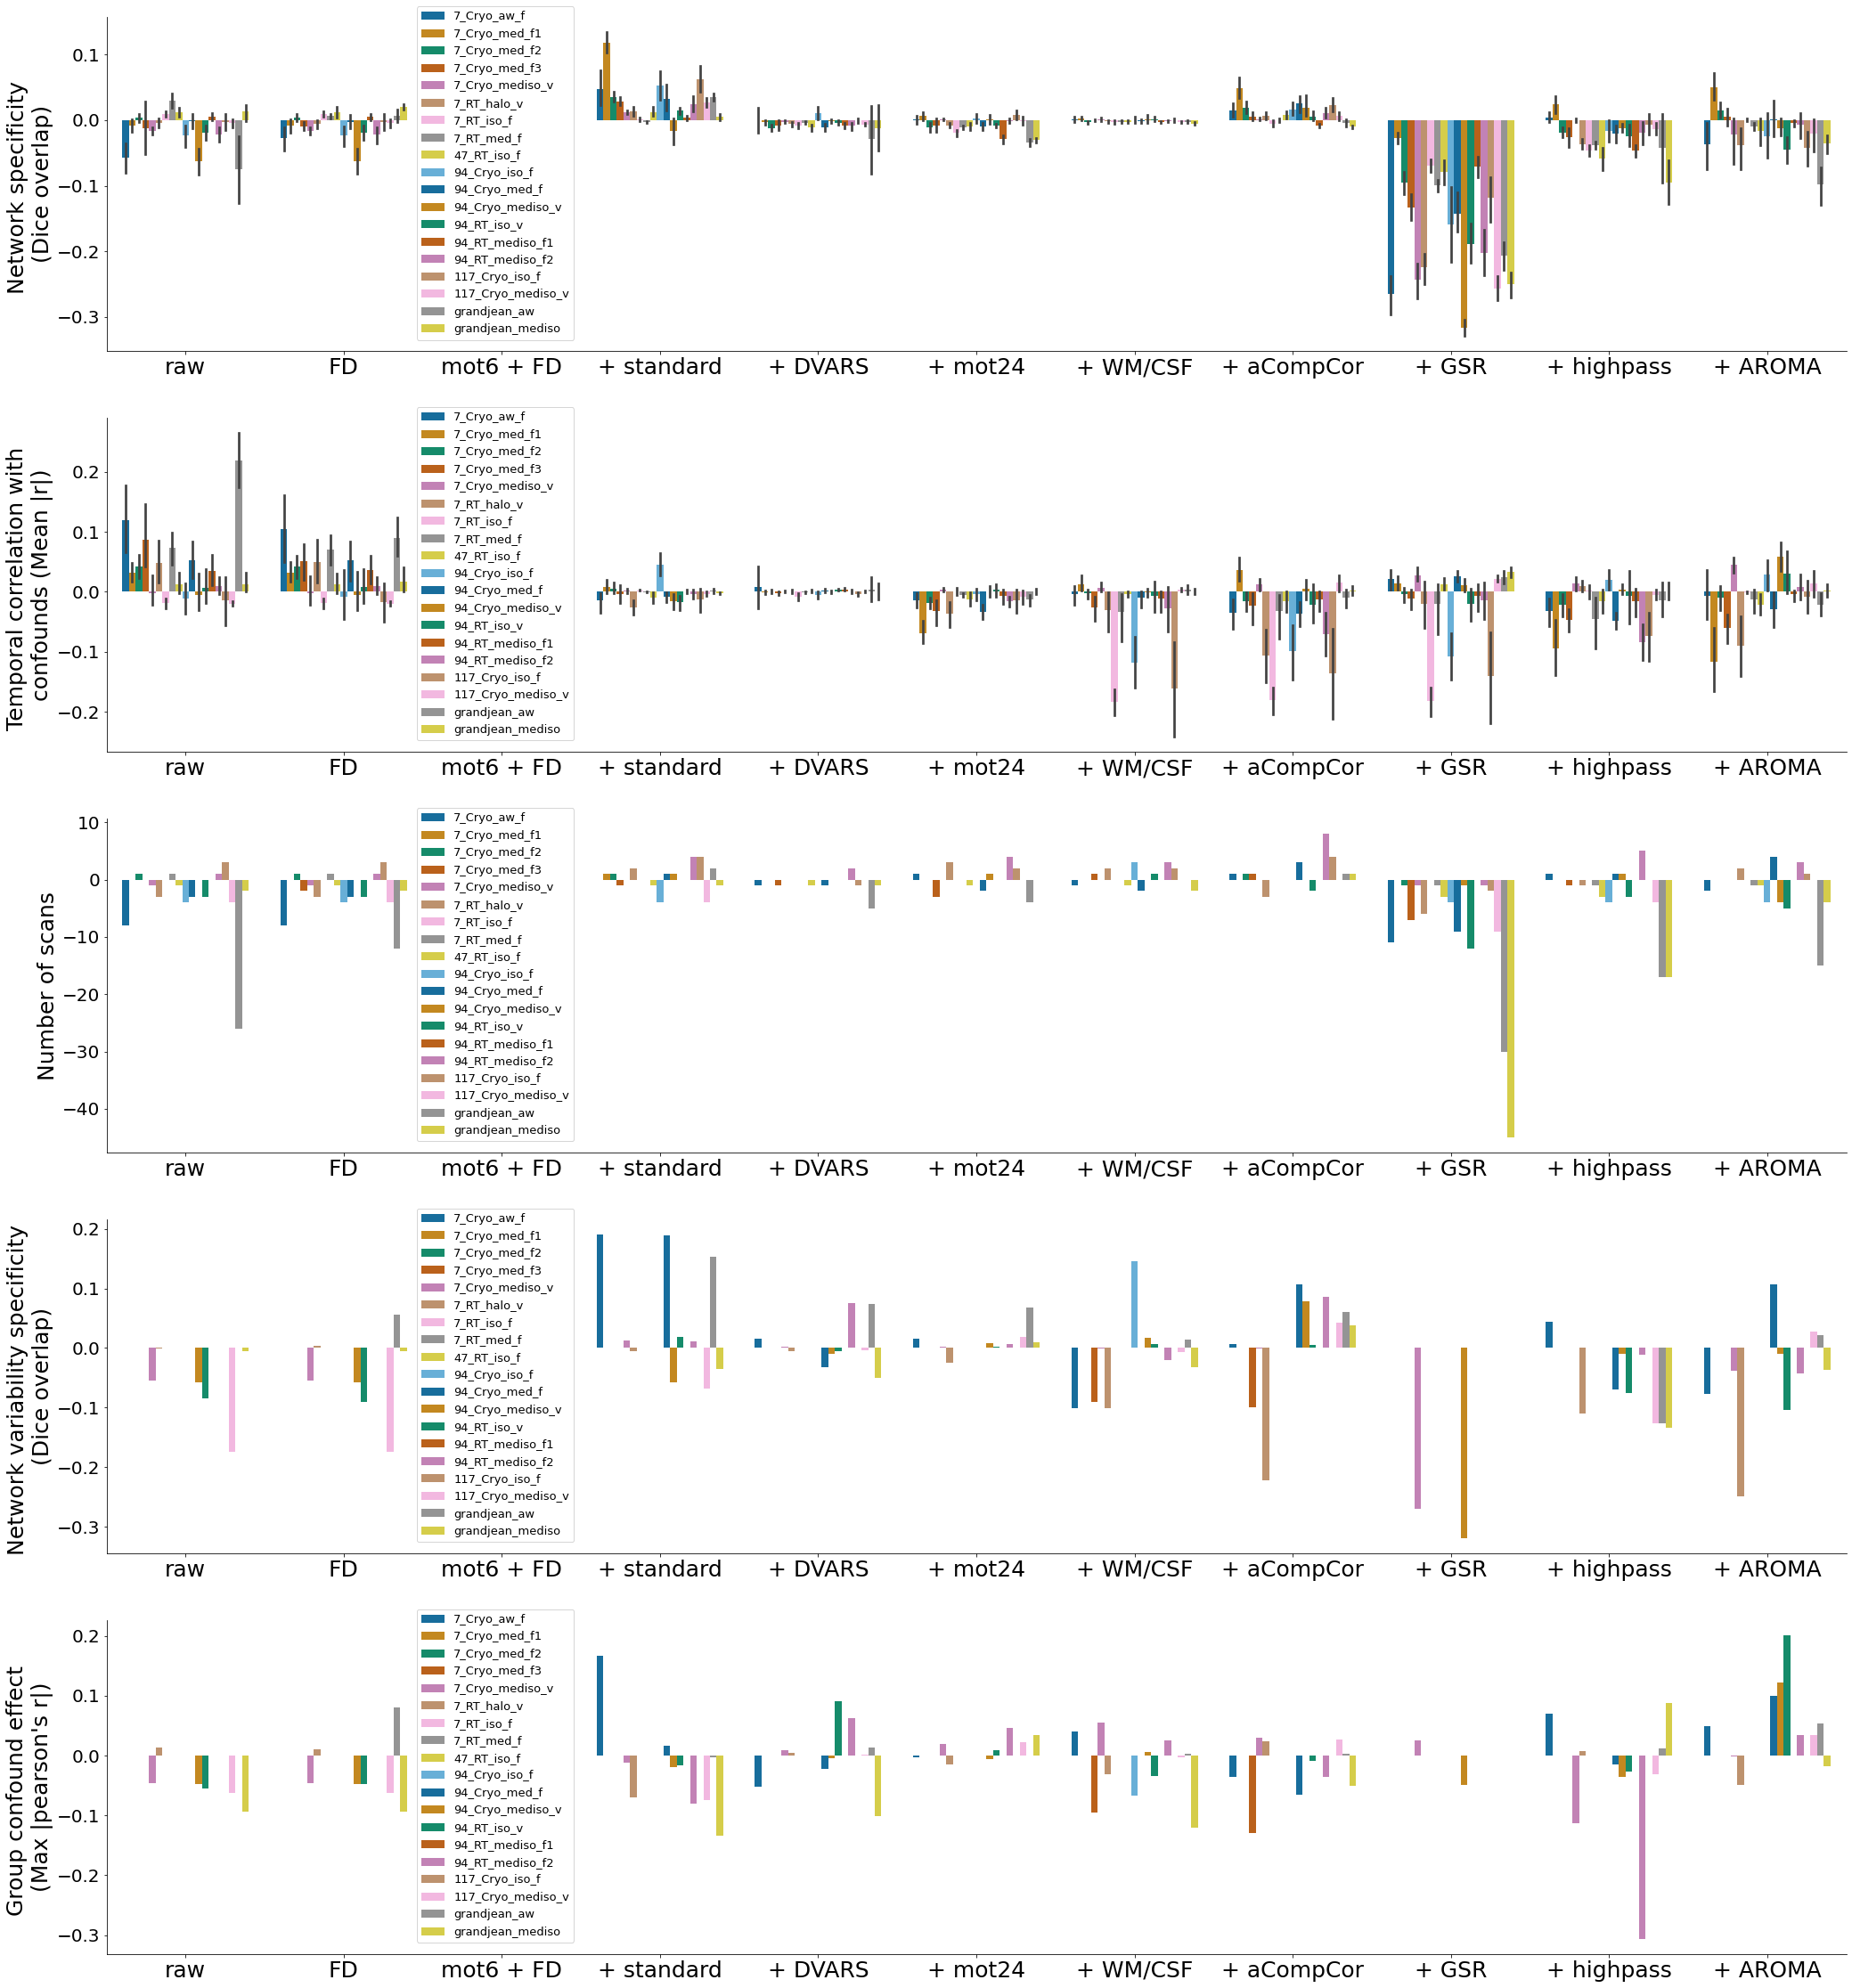

In [3]:
CR_list=['raw', 'FD', 'mot6_FD', 'mot6_FD_standard', 'mot6_FD_DVARS', 'mot24_FD', 
         'mot6_FD_WM_CSF', 'mot6_FD_aCompCor5', 'mot6_FD_global', 'mot6_FD_highpass', 'mot6_FD_AROMA']
CR_subset_name=['raw', 'FD', 'mot6 + FD', '+ standard', '+ DVARS', '+ mot24', '+ WM/CSF', '+ aCompCor', '+ GSR', '+ highpass', '+ AROMA']

ref_CR = 'mot6_FD'

FC_list=['DR0','seed_FC1','DR1','seed_FC0']
FC_list=['DR0']

for FC in FC_list:

    dice_df_list=[]
    conf_df_list=[]
    CR_df_list=[]
    dataset_df_list=[]
    num_scan_list=[]
    for dataset in datasets:
        for CR,CR_name in zip(CR_list, CR_subset_name):
            try:
                for dice,conf,dice_ref,conf_ref in zip(FC_stats[CR][FC][dataset]['Dice'],FC_stats[CR][FC][dataset]['Conf'],FC_stats[ref_CR][FC][dataset]['Dice'],FC_stats[ref_CR][FC][dataset]['Conf']):
                    dice_df_list.append(dice-dice_ref)
                    conf_df_list.append(conf-conf_ref)
                    CR_df_list.append(CR_name)
                    dataset_df_list.append(dataset)
                    num_scan_list.append(FC_stats[CR][FC][dataset]['num_scans'])
            except:
                continue

    arr = np.array([CR_df_list, dataset_df_list, dice_df_list,conf_df_list])
    df = pd.DataFrame(arr.T)
    df.columns = ['CR', 'dataset', 'Dice','Conf']
    df['Dice'] = df['Dice'].astype(float)
    df['Conf'] = df['Conf'].astype(float)



    CR_df_list=[]
    num_scan_list=[]
    max_corr_list=[]
    std_list=[]
    dataset_list=[]

    for dataset in datasets:
        # only group stats, because we still want num scans to be about the QC number
        ref_CR_group_stats = 'mot6_FD'
        if FC_stats[ref_CR_group_stats][FC][dataset]['num_scans']<8:
            ref_CR_group_stats = 'mot6_FD_no_QC'

        for CR,CR_name in zip(CR_list, CR_subset_name):
            try:
                if not FC_stats[CR][FC][dataset]['num_scans']<8:
                    STD_spec = FC_stats[CR][FC][dataset]['Overlap: Prior - Cross-scan variability']
                    FD_effect = np.abs(FC_stats[CR][FC][dataset]['Avg.: Mean FD'])
                    CR_effect = np.abs(FC_stats[CR][FC][dataset]['Avg.: CRsd'])
                    tDOF_effect = np.abs(FC_stats[CR][FC][dataset]['Avg.: tDOF'])
                    max_effect = max(FD_effect,CR_effect,tDOF_effect)

                    STD_spec_ref = FC_stats[ref_CR_group_stats][FC][dataset]['Overlap: Prior - Cross-scan variability']
                    FD_effect = np.abs(FC_stats[ref_CR_group_stats][FC][dataset]['Avg.: Mean FD'])
                    CR_effect = np.abs(FC_stats[ref_CR_group_stats][FC][dataset]['Avg.: CRsd'])
                    tDOF_effect = np.abs(FC_stats[ref_CR_group_stats][FC][dataset]['Avg.: tDOF'])
                    max_effect_ref = max(FD_effect,CR_effect,tDOF_effect)

                    std_list.append(STD_spec-STD_spec_ref)
                    max_corr_list.append(max_effect-max_effect_ref)
                else:
                    std_list.append(0)
                    max_corr_list.append(0)
                num_scan_list.append(FC_stats[CR][FC][dataset]['num_scans']-FC_stats[ref_CR][FC][dataset]['num_scans'])
                CR_df_list.append(CR_name)
                dataset_list.append(dataset)
            except:
                std_list.append(0)
                max_corr_list.append(0)
                CR_df_list.append(CR_name)
                dataset_list.append(dataset)
                num_scan_list.append(0)


    arr = np.array([CR_df_list,num_scan_list, max_corr_list,std_list,dataset_list])
    df_group = pd.DataFrame(arr.T)
    df_group.columns = ['CR', 'num_scans', 'Max corr', 'Cross-scan SD', 'dataset']
    df_group['num_scans'] = df_group['num_scans'].astype(float)
    df_group['Max corr'] = df_group['Max corr'].astype(float)
    df_group['Cross-scan SD'] = df_group['Cross-scan SD'].astype(float)



    import seaborn as sns

    fig,axes = plt.subplots(5,1,figsize=(35,40), facecolor='white')

    ax=axes[0]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    sns.barplot(ax=ax, y='Dice', x='CR', 
                 data=df, hue='dataset',
                 palette="colorblind")

    ax.legend(loc='upper left', bbox_to_anchor=(0.175, 1.05), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    plt.setp(ax.get_xticklabels(), fontsize=25)
    ax.set_xlabel("", fontsize=25)
    ax.set_ylabel("Network specificity \n(Dice overlap)", fontsize=25)

    ax=axes[1]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    sns.barplot(ax=ax, y='Conf', x='CR', 
                 data=df, hue='dataset',
                 palette="colorblind")
    ax.legend(loc='upper left', bbox_to_anchor=(0.175, 1.05), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    plt.setp(ax.get_xticklabels(), fontsize=25)
    ax.set_xlabel("", fontsize=25)
    ax.set_ylabel("Temporal correlation with \nconfounds (Mean |r|)", fontsize=25)

    ax=axes[2]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    sns.barplot(ax=ax, y='num_scans', x='CR', 
                 data=df_group, hue='dataset',
                 palette="colorblind")
    ax.legend(loc='upper left', bbox_to_anchor=(0.175, 1.05), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    plt.setp(ax.get_xticklabels(), fontsize=25)
    ax.set_xlabel("", fontsize=25)
    ax.set_ylabel("Number of scans", fontsize=25)

    ax=axes[3]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    sns.barplot(ax=ax, y='Cross-scan SD', x='CR', 
                 data=df_group, hue='dataset',
                 palette="colorblind")
    ax.legend(loc='upper left', bbox_to_anchor=(0.175, 1.05), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    plt.setp(ax.get_xticklabels(), fontsize=25)
    ax.set_xlabel("", fontsize=25)
    ax.set_ylabel("Network variability specificity \n(Dice overlap)", fontsize=25)

    ax=axes[4]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    sns.barplot(ax=ax, y='Max corr', x='CR', 
                 data=df_group, hue='dataset',
                 palette="colorblind")
    ax.legend(loc='upper left', bbox_to_anchor=(0.175, 1.05), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    plt.setp(ax.get_xticklabels(), fontsize=25)
    ax.set_xlabel("", fontsize=25)
    ax.set_ylabel("Group confound effect \n(Max |pearson's r|)", fontsize=25)